In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    RandomGenerator,
    Meshcat,
    MeshcatParams
)


import sponana.utils
import sponana.sim

In [3]:
# set host to 0.0.0.0 to enable port forwarding on remote server
meshcat = Meshcat(MeshcatParams(host="0.0.0.0"))

INFO:drake:Meshcat listening for connections at http://0.0.0.0:7000


In [4]:
import bayes3d

# precompile and cache the C++ plugin so we don't have to do that during simulation
bayes3d.rendering.nvdiffrast.common.ops._get_plugin(gl=True)

<module 'nvdiffrast_plugin_gl' from '/home/georgematheos/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_gl/nvdiffrast_plugin_gl.so'>

In [5]:
# spec1 = sponana.sim.TableSceneSpec(
#     has_banana=True,
#     banana_contact_params=(-0.17, 0.0, np.pi / 2, 0),
#     n_objects=2,
#     # Cracker boxes
#     object_type_indices=[0, 0],
#     object_contact_params=[(0.02, -0.08, 0, 2), (0.1, 0.1, 0, 2)],
# )

spec0 = sponana.sim.TableSceneSpec(
    has_banana=True,
    banana_contact_params=(0.1, 0.0, 3 * np.pi / 2, 0),
    n_objects=0,
    object_type_indices=[],
    object_contact_params=[],
)
spec1 = sponana.sim.TableSceneSpec(
    has_banana=False,
    banana_contact_params=(-0.17, 0., np.pi/2, 0),
    n_objects=3,
    # Cracker boxes
    object_type_indices=[0, 0, 0],
    object_contact_params=[(.05, -.18, np.pi/2, 1), (.05, .18, np.pi/2, 1), (.05, .0, np.pi/2, 1)]
)
# spec1 = sponana.sim.TableSceneSpec(
#     has_banana=False,
#     banana_contact_params=(-0.17, 0.0, np.pi / 2, 0),
#     n_objects=2,
#     # Cracker boxes
#     object_type_indices=[0, 0],
#     object_contact_params=[(0.02, -0.08, 0, 2), (0.1, 0.1, 0, 2)],
# )
# sponana.sim.TableSceneSpec(
#     has_banana=False,
#     banana_contact_params=(0, 0, 0, 0), # doesn't matter
#     n_objects=2,
#     object_type_indices=[1, 3], # sugar, mustard
#     object_contact_params=[(0.02, -0.08, 0, 2), (0.1, 0.1, 0, 1)],
# )
spec2 = sponana.sim.TableSceneSpec(
    has_banana=False,
    banana_contact_params=(0, 0, 0, 0), # doesn't matter
    n_objects=2,
    object_type_indices=[4, 1], # gelatin, cracker box
    object_contact_params=[(0.02, -0.08, 0, 2), (-0.1, 0.1, 0, 2)],
)

specs = [spec1, spec0, spec2]
# specs = [spec1, sponana.sim.TableSceneSpec(), sponana.sim.TableSceneSpec()]

In [6]:
rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

logging.root.setLevel(logging.INFO)
# logging.root.setLevel(logging.DEBUG)  # Uncomment to enable debug logging.

fsm_logger = logging.getLogger("sponana.fsm")
fsm_logger.setLevel(logging.INFO)

bs_logger = logging.getLogger("sponana.perception")
bs_logger.setLevel(logging.INFO)

simulation_time = 1
# simulation_time = 1
add_debug_logger = True
add_fixed_cameras = False
use_teleop = False
plot_camera_input = True

simulator, diagram = sponana.sim.create_and_run_simulation(
    meshcat,
    rng,
    add_debug_logger=add_debug_logger,
    simulation_time=simulation_time,
    add_fixed_cameras=add_fixed_cameras,
    use_teleop=use_teleop,
    plot_camera_input=plot_camera_input,
    table_specs=specs,
    use_naive_fsm=False
)

Press Space to log system info


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

INFO:sponana.planner.navigator:Generating path from [ 3.    7.   -1.57] to [ 1.          4.         -3.13316598]


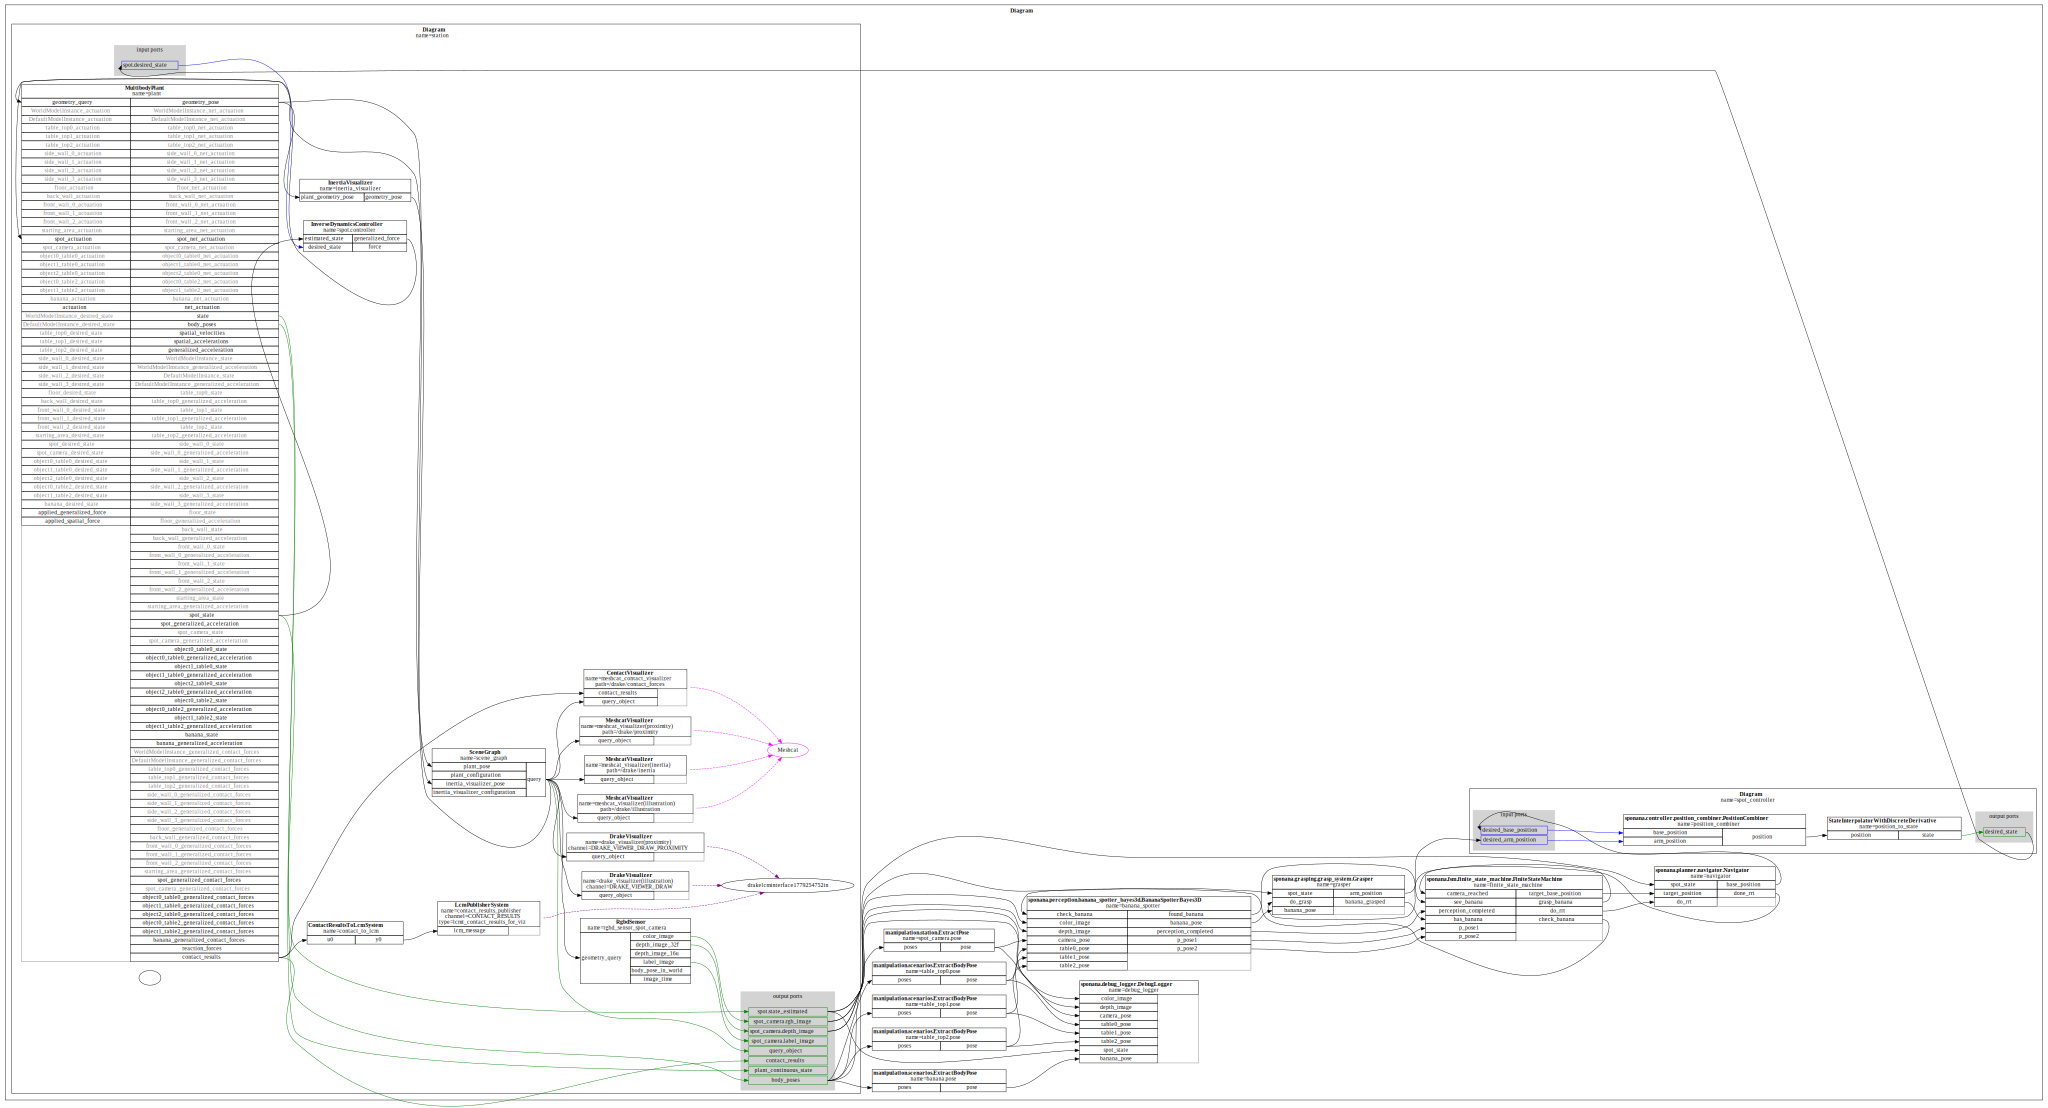

In [7]:
sponana.utils.visualize_diagram(diagram, max_depth=2)

In [ ]:
# Check the camera on Spot
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("spot_camera.rgb_image").Eval(context)
depth_image = station.GetOutputPort("spot_camera.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [ ]:
# camera intrinsics
camera1 = station.GetSubsystemByName("rgbd_sensor_spot_camera")
camera_info = camera1.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

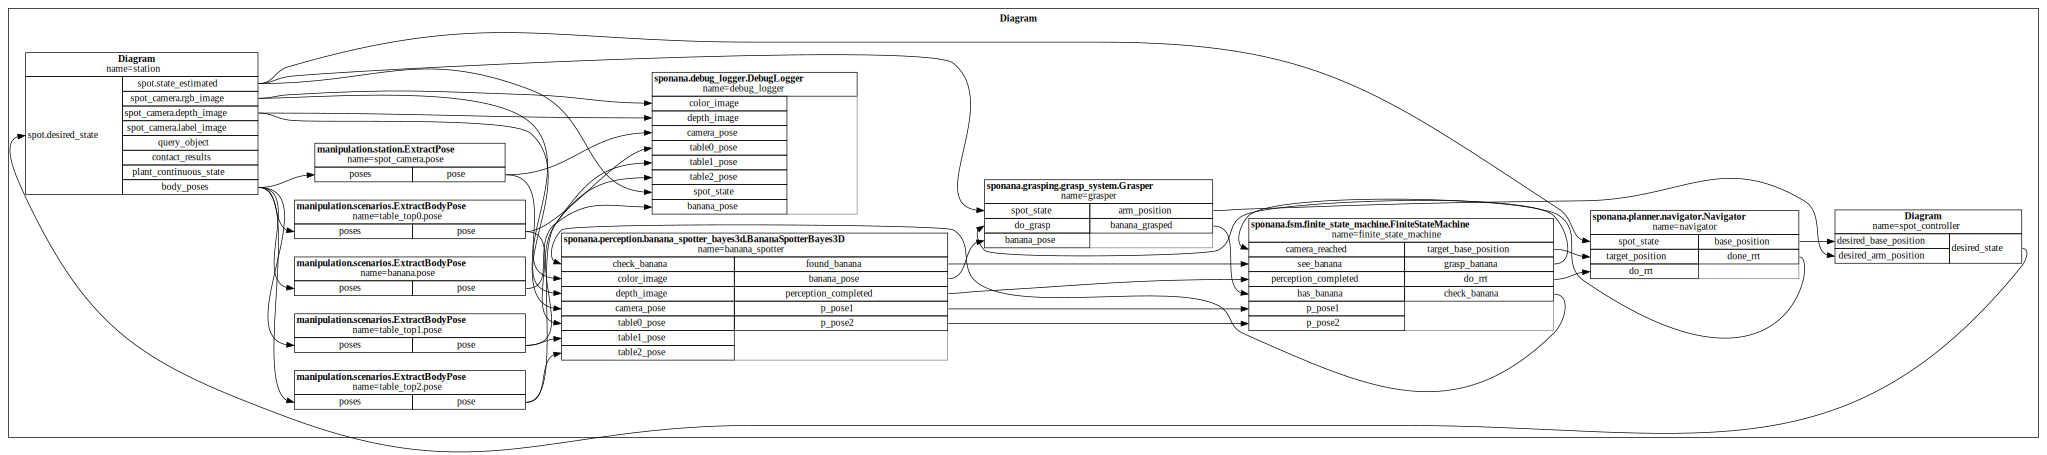

In [ ]:
from sponana.hardcoded_cameras import get_base_positions_for_hardcoded_cameras

get_base_positions_for_hardcoded_cameras()

In [ ]:
get_base_positions_for_hardcoded_cameras().shape